In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm

# Read data

In [5]:
listings_file_path = '../data/airbnb/listings.csv'
al_file_path = '../data/Alojamento_Local.csv'
df_al = pd.read_csv(al_file_path)
df_listings = pd.read_csv(listings_file_path)

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# General schema

![Star schema](schema.png)

# Exploratory data analysis

In [6]:
def missing_data(df, columns):
    """Calculates the amount of missing data in given DataFrame's selected columns"""
    df_graph = df[columns]
    # missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percent', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

def feature_dist(df, column_name):
    plt.figure(figsize=(15,4))
    sns.distplot(df[column_name] , fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[column_name])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(column_name))
    plt.show()

#IN BAR CHARTS, SET PERCENTAGES ABOVE EACH BAR
def set_bar_percentage(ax, df):
    for p in ax.patches:
        ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='center', rotation=0, xytext=(0, 10),
          textcoords='offset points')
        
#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')
        
#Simple plot
def simple_plot(df,column):
    bx = sns.catplot(x=column,data=df, kind='count')
    (bx.set_axis_labels(column, "Count")
        .set_titles("{col_name} {col_var}")
        .despine(left=True))

## Merge _df_listings_ with _alojamento_local.csv_

In [7]:
def intTryParse(value):
    """Tries to parse string to an integer"""
    try:
        a = int(value)
        return True
    except ValueError:
        return False

In [20]:
# get only listings where 
df_listings_with_license = df_listings[(~df_listings['license'].isnull()) #'license' is not null
                                        & (df_listings['license'] != 'Exempt')] # && != 'Exempt'

# string replace
df_listings_with_license['NrRNAL'] = [s.replace('/AL','').replace('.','') # remove '/AL' and '.' from code
                                      for s in df_listings_with_license['license']]

# get only records where license nr can be converted to int 
df_listings_with_license = df_listings_with_license[[intTryParse(s) # if code can be converted to int
                                                     for s in df_listings_with_license['NrRNAL']]] # keep it

# convert NrRNAL to int before merge the two dataframes
df_listings_with_license['NrRNAL'] = df_listings_with_license['NrRNAL'].astype(np.int64) # convert code to int

# inner join two dataframes
df_result = pd.merge(df_listings_with_license, df_al, how='inner', on='NrRNAL')

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
print('Dataset size: {}'.format(len(df_result)))

Dataset size: 17168


## Missing data

Singling out the columns of interest for this dimension, we analyse the distribution of missing values.

                    Total   Percent
host_response_time   1691  0.098497
host_location          21  0.001223
host_verifications      0  0.000000
host_is_superhost       0  0.000000
host_since              0  0.000000
host_name               0  0.000000


Text(0.5, 1.0, 'Host dimension missing data')

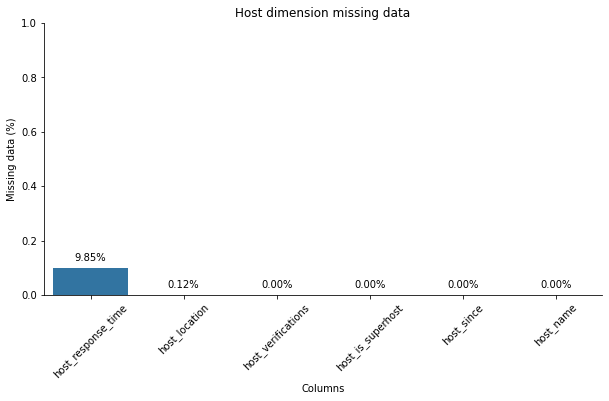

In [24]:
columns = [
'host_name',
'host_since',
'host_location',
'host_response_time',
'host_is_superhost',
'host_verifications'
]
ax = missing_data(df_result,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Missing data (%)')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Host dimension missing data')

## Host dimension

**host_name**

varchar(40), no missing data

In [28]:
print(df_result['host_name'])

0                  Ellie
1                Bárbara
2                 Mónica
3              Francisco
4              Francisco
              ...       
17163    Feels Like Home
17164             Raquel
17165             Raquel
17166             Simone
17167              Fábio
Name: host_name, Length: 17168, dtype: object


**host_since**

date AAAA-MM-DD

In [27]:
df_result['host_since']

0        2010-04-12
1        2010-05-16
2        2010-05-17
3        2010-05-19
4        2010-05-19
            ...    
17163    2012-10-23
17164    2012-05-31
17165    2012-05-31
17166    2019-12-07
17167    2016-01-17
Name: host_since, Length: 17168, dtype: object

**host_country**

-- Need to extract countries

Attention -- 21 missing values - probably delete rows

In [24]:
print(df_result['host_location'].value_counts())

Lisbon, Lisbon, Portugal         9020
PT                               2845
Portugal                          744
Cascais, Lisbon, Portugal         584
Sintra, Lisbon, Portugal          311
                                 ... 
Rio Maior, Santarém, Portugal       1
Copenhagen, Denmark                 1
Dallas, Texas, United States        1
Santa Cruz, Madeira, Portugal       1
Portugal, Moçambique e India        1
Name: host_location, Length: 618, dtype: int64


**host_country_gdp**

Source: https://data.worldbank.org/indicator/ny.gdp.pcap.cd

In [34]:
gdp_file_path = '../data/GDP per capita (worldbank).csv'
df_gdp = pd.read_csv(gdp_file_path)

df_gdp

,Country Name,Continent Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,Asia,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773194,59.860874,58.458015,78.706388,82.095231,...,438.076034,543.303042,591.162347,641.872034,637.165044,613.856333,578.466353,547.228110,556.302138,520.896603
1,Albania,Europe,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,...,4114.140150,4094.362119,4437.178067,4247.614279,4413.081743,4578.666720,3952.829458,4124.108907,4532.890162,5268.848504
2,Algeria,Africa,DZA,GDP per capita (current US$),NY.GDP.PCAP.CD,246.308763,214.776273,172.245998,226.899989,238.048532,...,3883.378143,4480.724539,5455.741338,5592.326098,5499.581487,5493.025590,4177.867517,3946.421445,4044.298372,4114.715061
3,American Samoa,Oceania,ASM,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,...,11961.258230,10271.224520,10294.302270,11568.793000,11505.393710,11507.232350,11843.331180,11696.955560,10823.444800,11466.690710
4,Andorra,Europe,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,...,43338.866760,39736.354060,41100.729940,38392.943900,40626.751630,42300.334130,36039.653500,37224.108920,39134.393370,42029.762740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,West Bank and Gaza,Asia,PSE,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,...,1970.182963,2354.125987,2695.193853,2834.021525,3060.312389,3046.821798,2967.851747,3074.291152,3254.485887,3198.866644
212,"Yemen, Rep.",Asia,YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,...,1116.084594,1334.784845,1374.621313,1446.536280,1607.152275,1674.002766,1608.744312,1139.870568,963.494721,944.408499
213,Zambia,Africa,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,232.188867,220.042137,212.578123,213.896441,242.384333,...,1159.907762,1489.459070,1672.949830,1763.094184,1878.903489,1763.056239,1337.796315,1280.578447,1534.865371,1539.900158
214,Zimbabwe,Africa,ZWE,GDP per capita (current US$),NY.GDP.PCAP.CD,278.813699,280.828950,276.688781,277.479715,281.558440,...,771.598786,948.331854,1093.654002,1304.969802,1430.000818,1434.899340,1445.071062,1464.583529,1602.403507,2146.996385


**host_continent**

In [33]:
continents = df_gdp['Continent Name']

**host_response_time**

{'within an hour','within a few hours','within a day','a few days or more'}

Attention -- 1691 missing values - delete rows or replace with 'unkwown'

In [18]:
print(df_result['host_response_time'].value_counts())

within an hour        12943
within a few hours     1506
within a day            884
a few days or more      144
Name: host_response_time, dtype: int64


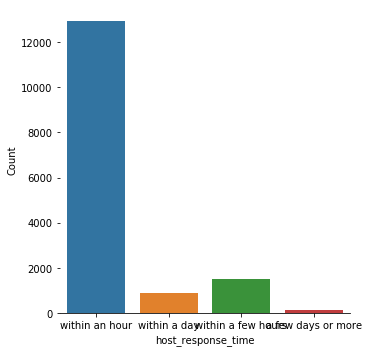

In [19]:
simple_plot(df_result, 'host_response_time')

**host_is_superhost**

Change to "Superhost" and "Not Superhost"

In [43]:
print(df_result['host_is_superhost'].value_counts())

for index, row in enumerate(df_result['host_is_superhost'], start = 0):
 if row == 't':
  df_result.loc[index, 'host_is_superhost'] = "Superhost"
 elif row == 'f':
  df_result.loc[index, 'host_is_superhost'] = "Not Superhost"

print(df_result['host_is_superhost'].value_counts())

Not Superhost    11879
Superhost         5289
Name: host_is_superhost, dtype: int64
Not Superhost    11879
Superhost         5289
Name: host_is_superhost, dtype: int64


**host_identity_verified**

-- Change to "Verified" and "Not Verified"

In [44]:
print(df_result['host_identity_verified'].value_counts())

for index, row in enumerate(df_result['host_identity_verified'], start = 0):
 if row == 't':
  df_result.loc[index, 'host_identity_verified'] = "Verified"
 elif row == 'f':
  df_result.loc[index, 'host_identity_verified'] = "Unverified"

print(df_result['host_identity_verified'].value_counts())

f    12200
t     4968
Name: host_identity_verified, dtype: int64
Unverified    12200
Verified       4968
Name: host_identity_verified, dtype: int64
